In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.nn.functional as F 

import torchvision 
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [2]:
# CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [3]:
# fashion_mnist 데이터셋 내려받기
DATA_PATH = '/Users/anhyojun/WorkSpace/Local Data'
train_dataset = torchvision.datasets.FashionMNIST(DATA_PATH, download=True,
                                                  transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST(DATA_PATH, download=True,
                                                 train=False, transform=transforms.Compose([transforms.ToTensor()]))

In [5]:
# fashion_mnist 데이터를 데이터로더에 전달
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size = 100)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size = 100)

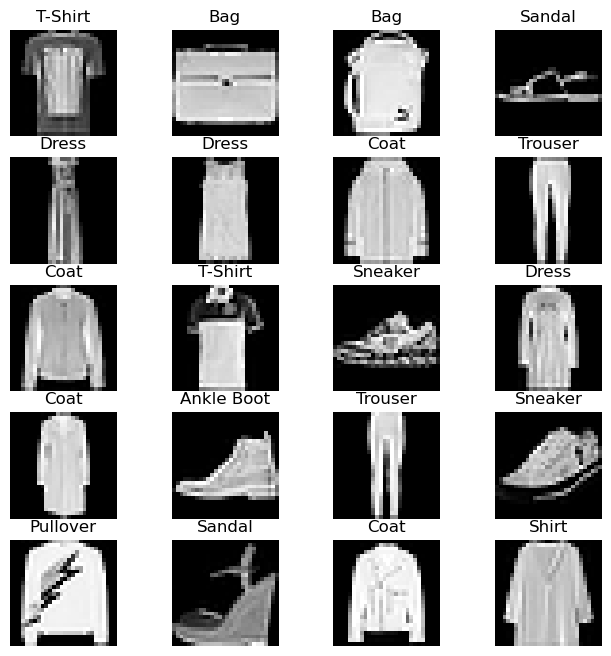

In [38]:
# 분류에 사용될 클래스 정의
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize = (8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

In [39]:
# 심층 신경망 모델 생성
class FashionDNN(nn.Module):
    def __init__(self):
        # 명시적으로 FashionDNN과 self를 전달하여
        # 부모 클래스(nn.Module)의 초기화 메서드를 호출
        # 파이썬 2의 문법에서 사용되던 방식으로 3에서는 생략 가능
        super(FashionDNN, self).__init__()
        self.fc1 = nn.Linear(in_features=784, out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, input_data):
        out = input_data.view(-1, 784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [62]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001
model = FashionDNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [76]:
# 심층 신경망을 이용한 모델 학습
num_epochs = 5 # 5번 반복
count = 0
loss_list = [] # 각종 데이터를 저장할 리스트 초기화
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 5번 반복
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Variable : Pytorch에서 데이터를 감싸는 도구
        # 옛날에는 필요했지만, 지금은 더 이상 사용하지 않아도 됨
        # 지금은 torch.Tensor만 사용해도 됨
        # train = images.view(100, 1, 28, 28)만 써도 됨
        # view는 Pytorch에서 텐서의 모양(크기, 차원)을 바꾸는 함수
        # 원래 image가 (100, 28, 28) 모양이었다면
        # 이를 (100, 1, 28, 28)로 바꾸는 역할을 함
        # 이렇게 변환해야 CNN 모델이 올바르게 이미지 처리 가능
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # 그레디언트 초기화
        loss.backward() # 모델 가중치 업데이트 위한 기울기 계산
        optimizer.step() # 가중치 조절해 학습 진행
        count += 1

        if not (count % 50): # 50번 마다 성능 확인
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.5969437956809998, Accuracy: 82.86000061035156%
Iteration: 1000, Loss: 0.4707275331020355, Accuracy: 83.9000015258789%
Iteration: 1500, Loss: 0.36890262365341187, Accuracy: 83.95999908447266%
Iteration: 2000, Loss: 0.3785523474216461, Accuracy: 85.22000122070312%
Iteration: 2500, Loss: 0.24682100117206573, Accuracy: 86.19999694824219%
Iteration: 3000, Loss: 0.27647697925567627, Accuracy: 86.62999725341797%


In [86]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module): # 클래스 정의
    def __init__(self): # CNN 모델 초기화
        super(FashionCNN, self).__init__() # 부모 클래스 nn.Module 초기화 (nn.Module 기능 사용 가능)
        self.layer1 = nn.Sequential( # 첫 번째 합성곱 계층 정의
            # in_channels : 입력 이미지의 채널 수 (흑백이라 1), out_channels : 합성곱 거친 후 출력할 특징 맵 개수
            # kernel_size : 3x3 크기의 커널(필터) 사용하여 특징 추출
            # padding : 입력 이미지 크기 유지하기 위해 패딩 적용
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), # 배치 정규화 계층 (32개의 출력 채널에 대해 배치 정규화 수행)
            nn.ReLU(), # 활성화 함수 (비선형성을 추가하여 모델이 복잡한 패턴 학습 가능하게 함)
            nn.MaxPool2d(kernel_size=2, stride=2) # 맥스 풀링 계층 (공간 크기 줄이면서 주요 특징 남김)
            # kernel_size : 2x2 영역에서 가장 큰 값 선택
            # stride : 2칸씩 이동하면서 풀링 적용
        )
        self.layer2 = nn.Sequential( # 두 번째 합성곱 계층 정의
            # 32개의 채널을 입력받아 64개의 출력 특징 맵을 생성하는 합성곱 계층
            # 패딩이 없어 출력 후 크기가 줄어듦
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64), # 64개의 출력에 대해 배치 정규화 수행
            nn.ReLU(), # ReLU 활성화 함수 적용
            nn.MaxPool2d(2) # 2x2 맥스 풀링 적용 (크기 절반으로 줆)
        )
        # 첫 번째 전결합층 (fully connected layer)
        # in_features : 두 번째 합성곱 계층에서 나온 데이터 평탄화 한 후 전결합층에 입력
        # 각 이미지에서 64개의 6x6 특징 맵을 생성 후 이를 일렬로 나열해 입력
        # out_features : 600개의 출력 노드 생성
        self.drop = nn.Dropout2d(0.25) # 25%의 뉴런을 학습 중 무작위로 비활성화 (과적합 방지)
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        # 두 번째 전결합층
        # in_features : 이전 층에서 600개의 입력을 받아들임
        # out_features : 120개의 출력 노드 생성
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        # 마지막 전결합층
        # in_features : 120개의 입력을 받아들임
        # out_features : 최종적으로 10개의 클래스로 분류
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x) # 입력 데이터를 첫 번째 합성곱 계층에 통과
        out = self.layer2(out) # 첫 번째 계층의 출력을 두 번째 합성곱 계층에 통과

        # 만약 out 텐서가 (32, 64, 6, 6)의 크기를 가진다면
        # (32는 배치 크기, 64는 채널 수, 6x6은 각 채널의 공간 크기)
        # 아래 결과는 (32, 64*6*6)의 크기가 된다
        out = out.view(out.size(0), -1) # 평탄화 단계 (2D를 전결합층에 넣기 위해 1D로 변환)
        out = self.drop(out) # 드롭아웃 적용하여 일부 뉴런 비활성화
        out = self.fc1(out) # 첫 번째 전결합층에 입력
        out = self.fc2(out) # 두 번째 전결합층에 입력
        out = self.fc3(out) # 마지막 전결합층에 입력 (10개 클래스에 대한 확률 계산)
        return out # 최종 출력 반환
    
# 참고
# 1. Conv2d 계층에서의 출력 크기 구하는 공식
# 출력 크기 = (W-F+2P)/S+1
# W : 입력 데이터의 크기 (input_volume_size)
# F : 커널 크기 (kernel_size)
# P : 패딩 크기 (padding_size)
# S : 스트라이드 (strides)
# 2. MaxPool2d 계층에서의 출력 크기 구하는 공식
# 출력 크기 = IF/F
# IF : 입력 필터의 크기 (input_filter_size, 또한, 바로 앞의 Conv2d의 출력 크기이기도 함)
# F : 커널 크기 (kernel_size)

In [87]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001
model = FashionCNN()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [88]:
# 모델 학습 및 성능 평가
num_epochs = 5 # 5번 반복
count = 0
loss_list = [] # 각종 데이터를 저장할 리스트 초기화
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs): # 5번 반복
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Variable : Pytorch에서 데이터를 감싸는 도구
        # 옛날에는 필요했지만, 지금은 더 이상 사용하지 않아도 됨
        # 지금은 torch.Tensor만 사용해도 됨
        # train = images.view(100, 1, 28, 28)만 써도 됨
        # view는 Pytorch에서 텐서의 모양(크기, 차원)을 바꾸는 함수
        # 원래 image가 (100, 28, 28) 모양이었다면
        # 이를 (100, 1, 28, 28)로 바꾸는 역할을 함
        # 이렇게 변환해야 CNN 모델이 올바르게 이미지 처리 가능
        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad() # 그레디언트 초기화
        loss.backward() # 모델 가중치 업데이트 위한 기울기 계산
        optimizer.step() # 가중치 조절해 학습 진행
        count += 1

        if not (count % 50): # 50번 마다 성능 확인
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4818616211414337, Accuracy: 87.18000030517578%
Iteration: 1000, Loss: 0.29655465483665466, Accuracy: 88.66000366210938%
Iteration: 1500, Loss: 0.33144524693489075, Accuracy: 86.55999755859375%
Iteration: 2000, Loss: 0.22794272005558014, Accuracy: 89.55000305175781%
Iteration: 2500, Loss: 0.16484007239341736, Accuracy: 89.26000213623047%
Iteration: 3000, Loss: 0.19211149215698242, Accuracy: 88.94000244140625%
